# Natural Language Processing with Disaster Tweets
<div class="alert alert-block alert-info">
Peer-graded Assignment 4 for DTSA 5511 (Introduction to Deep Learning)<br>
</div>

## 1. Introduction

### 1.1 Background

Statement from the website: *Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example: The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine. In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.*


### 1.2 Objectives
This project is about building machine learning models on disaster tweet detection. The data is originated from Kaggle and the problem belongs to <font color='red'>binary classification problem</font>. Multiple machine learning and neural network models will be tested and compared in this project. Comparison will be based on classification evaluation metrics (accuracy, F1 score and area under ROC curve). Text data handling and analysis techniques required for model training are also main part of this study. In addition, hyperparamter tuning and training results comparison will be demostrated.

### 1.3 Data Source

- Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

Importing required packages:

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import cv2

Checking availability of GPU. This study will apply PyTorch framework for building and training neural network models.

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead.")

GPU is available and being used.


## 2. Data Preparation and Exploratory Data Analysis

### 2.1 Training vs Testing Data

There are two files in this dataset. <font color="blue">train.csv</font> contains training data with the following columns:
- id: a unique identifier for each tweet
- text: the text of the tweet
- location: the location the tweet was sent from (may be blank)
- keyword: a particular keyword from the tweet (may be blank)
- target: in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

<font color="blue">test.csv</font> contains test data and has the same strucutre as <font color="blue">train.csv</font> without the target column.

In [4]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### 2.2 Data Description (training data set)

- Number of training tweets: 7,613
- Training date storage usage: 297.5KB
- Number of test tweets: 3,263
- Test image storage usage: 102.1KB

Training data:
- Column Counts: 5
- Numerical Column Counts: 2
- Text Column Counts: 3
- Column of Target Variable: target

### 2.3 Distribution of Labels
Examine distribution of the label values. The data is only mild unbalanced <font color="blue">(57%:43%)</font> hence no special treatment will be planned.

In [5]:
df_train["target"].value_counts(normalize = True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

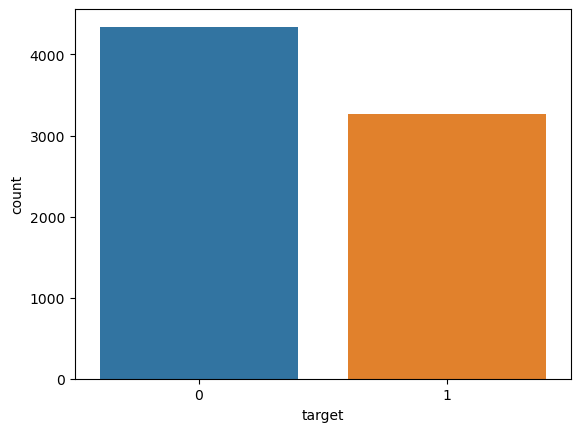

In [6]:
sns.countplot(data = df_train, x = "target")
plt.show()

### 2.4 Training Tweets Analysis
We first randomly list 20 tweets from the training data, they are typical tweets with mentions(<font color="blue">#</font>), hashtag(<font color="blue">@</font>), hyperlink, special character, and emoji in addtion to normal description.

In [7]:
idx = np.random.choice(len(df_train), 20, replace=False)
for id in idx:
    print(df_train.iloc[id]["target"], ": ", df_train.iloc[id]["text"])

0 :  Businesses are deluged with invoices. Make yours stand out with colo r or shape and it's lzkely to rise to the top of the pay' pile.
1 :  @dreamoforgonon @TeeEss not to hijack but as a bona fide cislady I can confirm this as true; incidental homosexuality =/= gay/bi for women.
0 :  Being able to stay out of work this week to take online courses for the Property and Casualty StateÛ_ https://t.co/jmD7zwKSDM
0 :  Why did God order obliteration of ancient Canaanites? http://t.co/Sf2vwQvJYa
1 :  @iateyourfood yikes.  Poor pup.  What a weird violent storm.
0 :  Despite the deluge of #FantasticFour notices our man O'Cuana is still buying tickets - because he's bloody-minded like that.
1 :  Solitude Fire Update August 6 2015 (Solitude Wildfire): Summary: This lightning-caused fire is being ... http://t.co/4eSbsA8InT #UTFire
1 :  GAElite 0    Explosion Greg 2 [Top 3rd] [0 Out] [0 balls] [0 strikes] ... No one on [P: #16 Morgan Orchard] [B: ]
1 :  RT @kotowsa: South SudanÛªs war on women:

We then analysis if there is discernible difference in patterns between disaster and non-disaster tweets:
- Number of characters
- Number of words
- Number of hashtags
- Number of mentions
- Number of hyperlinks

We can observe some minor difference in patterns of hyperlink: disaster tweets tend to be more likely to have hyperlink than non-disaster ones. Both type of tweets share similar structure in other characteristics.

In [8]:
df_train["num_chars"] = df_train["text"].apply(len)
df_train["num_words"] = df_train["text"].apply(lambda x: len(x.split()))
df_train["num_hashtags"] = df_train["text"].apply(lambda x: x.count("#"))
df_train["num_mentions"] = df_train["text"].apply(lambda x: x.count("@"))
df_train["num_hyperlinks"] = df_train["text"].apply(lambda x: x.lower().count("http://") + x.lower().count("https://"))

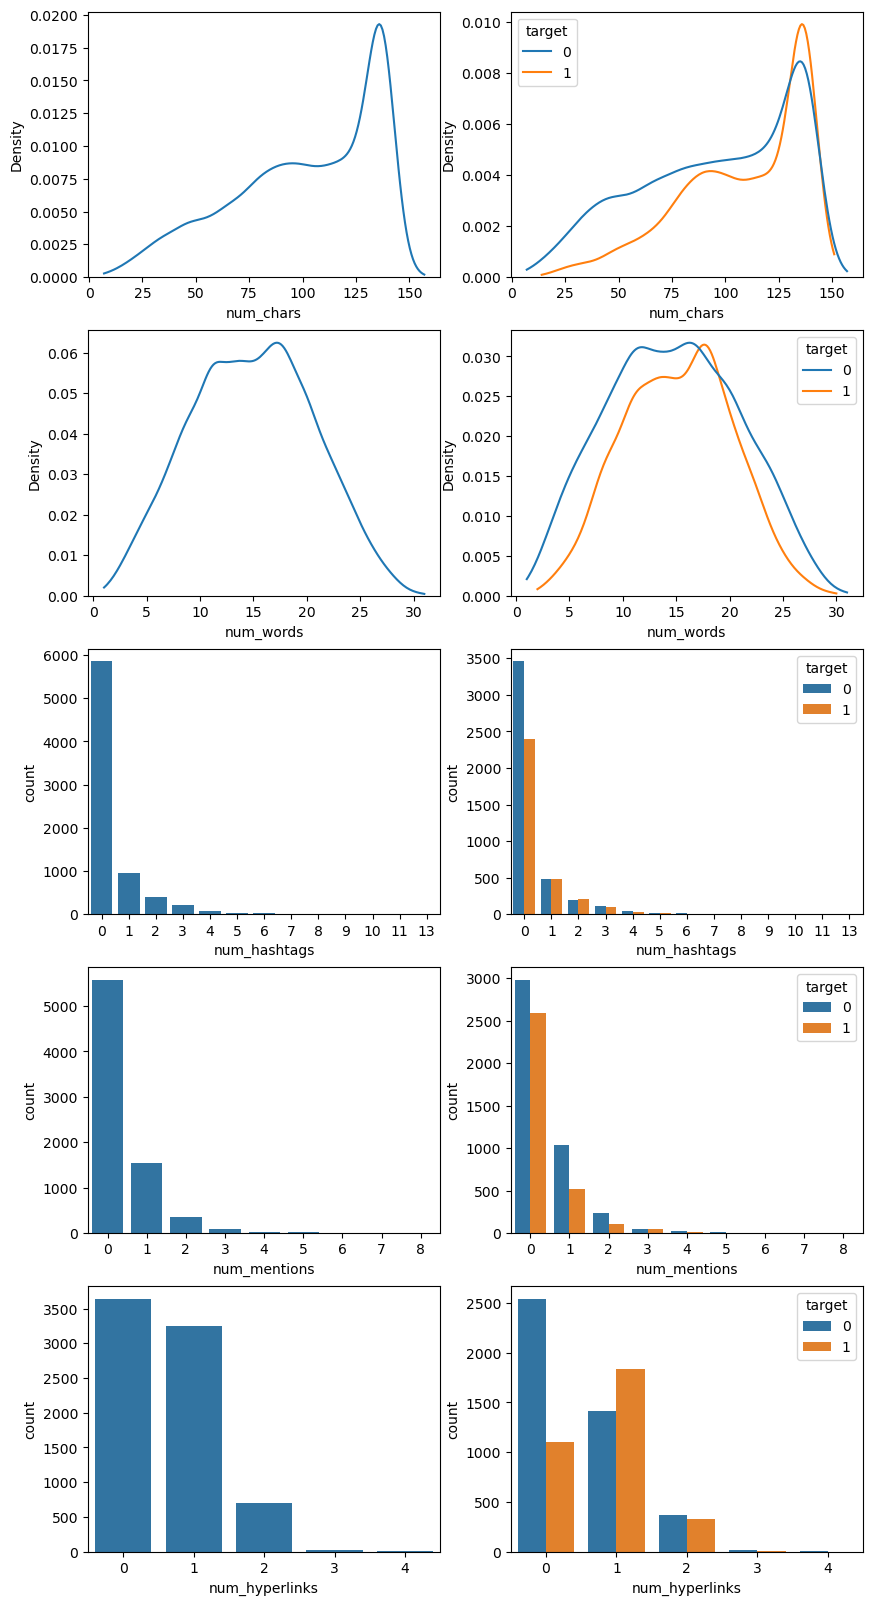

In [9]:
fig, ax = plt.subplots(5, 2, figsize = (10, 20), subplot_kw = {"xlabel": None})
sns.kdeplot(data = df_train, x = "num_chars", cut = 0, ax = ax[0, 0])
sns.kdeplot(data = df_train, x = "num_chars", hue = "target", cut = 0, ax = ax[0, 1])
sns.kdeplot(data = df_train, x = "num_words", cut = 0, ax = ax[1, 0])
sns.kdeplot(data = df_train, x = "num_words", hue = "target", cut = 0, ax = ax[1, 1])
sns.countplot(data = df_train, x = "num_hashtags", color = "tab:blue", ax = ax[2, 0])
sns.countplot(data = df_train, x = "num_hashtags", hue = "target", ax = ax[2, 1])
sns.countplot(data = df_train, x = "num_mentions", color = "tab:blue", ax = ax[3, 0])
sns.countplot(data = df_train, x = "num_mentions", hue = "target", ax = ax[3, 1])
sns.countplot(data = df_train, x = "num_hyperlinks", color = "tab:blue", ax = ax[4, 0])
sns.countplot(data = df_train, x = "num_hyperlinks", hue = "target", ax = ax[4, 1])
plt.show()

### 2.5 Location and Keyword Analysis

- Values of location are diverse and show no obvious relation to the target value. Also, 33% of them are empty so we will simply discard this column.
- On the other hand, some values of keyword have strong implication on the target value. For example, tweets with keywords "debris", "wreckage", and "derailment" are 100% disastrous; tweets with keywords "aftershock" are 100% non-disastrous. Including keywords in the model should help classifying our tweets.

In [10]:
num_keyword = np.sum(~df_train["keyword"].isna())
num_unique_keyword = df_train["keyword"].nunique()
num_location = np.sum(~df_train["location"].isna())
num_unique_location = df_train["location"].nunique() 
print("Number of non-NaN keyword: ", str(num_keyword), ", Number of non-NaN location: ", str(num_location))
print("Number of unique keyword: ", str(num_unique_keyword), ", Number of unique location: ", str(num_unique_location))

Number of non-NaN keyword:  7552 , Number of non-NaN location:  5080
Number of unique keyword:  221 , Number of unique location:  3341


In [12]:
for i in range(20):
    print(df_train[~df_train["location"].isna()]["location"].iloc[i])

Birmingham
Est. September 2012 - Bristol
AFRICA
Philadelphia, PA
London, UK
Pretoria
World Wide!!
Paranaque City
Live On Webcam
milky way
GREENSBORO,NORTH CAROLINA
Live On Webcam
England.
Sheffield Township, Ohio
India
Barbados
Anaheim
Abuja
USA
South Africa


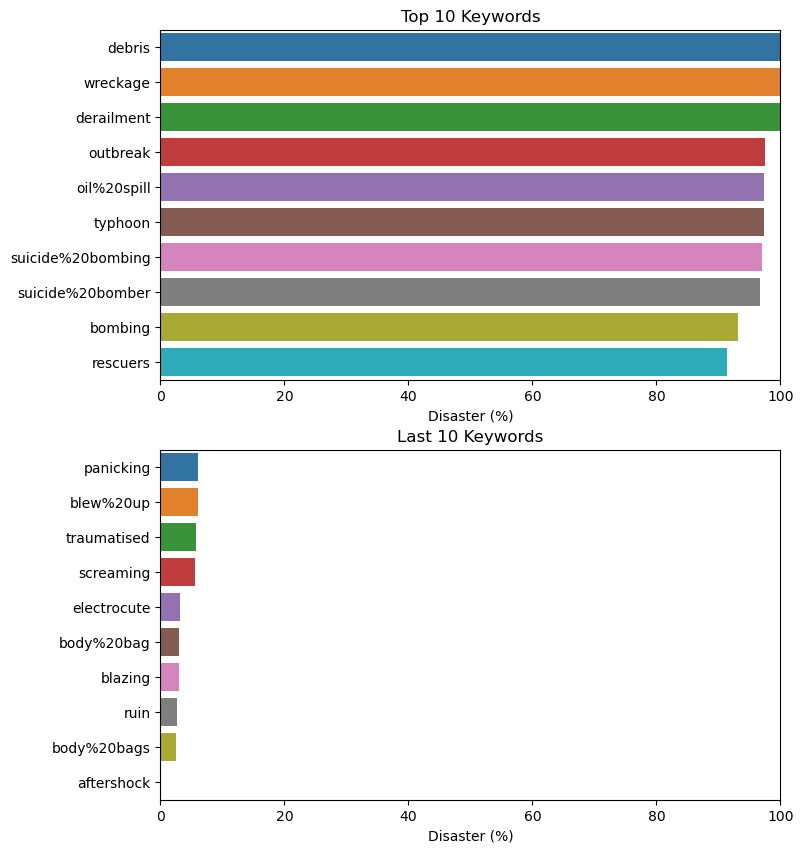

In [12]:
gb = df_train[["keyword", "target"]].groupby("keyword")
keyword_order = (100*gb.sum()/gb.count()).sort_values("target", ascending = False).reset_index()
fig, ax = plt.subplots(2, 1, figsize = (8, 10))
sns.barplot(data = keyword_order.head(10), x = "target", y = "keyword", ax = ax[0])\
                .set(ylabel = "", xlabel = "Disaster (%)", xlim = [0,100], title = "Top 10 Keywords")
sns.barplot(data = keyword_order.tail(10), x = "target", y = "keyword", ax = ax[1])\
                .set(ylabel = "", xlabel = "Disaster (%)", xlim = [0,100], title = "Last 10 Keywords")
plt.show()

### 2.6 Text Cleaning Strategy

- Add keywords to the tweets (we only use content of tweet for classification)
- Turn into lower case format
- Remove hashtag signs and leave the hashtag contents
- Remove mensions and hyperlinks
- Remove all stop words \[<font color="red">Stop words are common words (e.g., "the," "and," "in") that are often removed from text during natural language processing tasks. They have little semantic meaning on their own and are excluded to reduce computational overhead and focus on more important words for analysis.</font>\]
- Lemmatize words \[<font color="red">Lemmatization is a linguistic process that reduces words to their base or root form, called a lemma. It involves removing inflections and variations, ensuring words like "running" and "ran" are reduced to "run." Lemmatization aids in language normalization and improves semantic analysis accuracy.</font>\]
- Both training and test dataset will go through the above process

In [13]:
df_train["text"] = df_train["text"].str.cat(df_train["keyword"].apply(lambda x: "" if pd.isna(x) else x), sep = " ")
df_test["text"] = df_test["text"].str.cat(df_test["keyword"].apply(lambda x: "" if pd.isna(x) else x), sep = " ")

nlp = spacy.load("en_core_web_lg")
def clean_text(text):
    text = text.lower()
    text.replace("#", "")
    doc = nlp(text)
    tokens = []
    for token in doc:
        text = token.text
        if not (text.startswith("@") or text.startswith("http://") or text.startswith("https://") or
                    token.is_stop or not text.isalpha()):
            tokens.append(token.lemma_)
    return " ".join(tokens)

df_train["text"] = df_train["text"].apply(clean_text)
df_test["text"] = df_test["text"].apply(clean_text)

### 2.7 Text Vectorization

In this study, we apply two methods of text vectorization:
- TF-IDF (Term Frequency-Inverse Document Frequency): It evaluates a word's importance by combining its frequency in a document (TF) with its rarity across a corpus (IDF). High TF and low IDF suggest a significant word. Example: In a corpus, "cat" appears 4 times in a document with 100 words. Across the corpus of 1000 documents, "cat" is present in 100 documents. TF = 4/100 = 0.04, IDF = log(1000/100) = 2. TF-IDF = 0.04 * 2 = 0.08, indicating "cat" is moderately relevant to the document. We combine training and test dataset to make up the corpus for TF-IDF vectorization. Since some of the words appear in test dataset might not be in the training dataset.
- Word Embedding: Word embedding is a technique in deep learning that represents words as vectors in a continuous space. It maps words with similar meanings to nearby points, capturing semantic relationships. This dense numerical representation enhances natural language processing tasks by preserving contextual information. Popular methods like Word2Vec, GloVe, and fastText create these embeddings by analyzing large text corpora. These embeddings enable deep learning models to understand and work with words more effectively, improving tasks like sentiment analysis, machine translation, and text classification, as they encode semantic nuances, making them a fundamental component in many language-related AI applications. <font color="red">In this study, we use spacy library for the word embedding (with corpus en_core_web_lg)</font>.

In [14]:
vectorize = TfidfVectorizer()
tfidf_matrix = vectorize.fit_transform(np.concatenate([df_train["text"], df_test["text"]], axis = 0)).toarray()
X_tfidf = tfidf_matrix[:len(df_train), ]
X_test_tfidf = tfidf_matrix[len(df_train):, ]

In [15]:
vocab_vector_size = 300
seq_length = 21

X_w2v = np.zeros((len(df_train), seq_length,vocab_vector_size))
X_test_w2v = np.zeros((len(df_test), seq_length,vocab_vector_size))

for i in range(len(df_train)):
    if df_train["text"][i] == "":
        continue
    doc = nlp(df_train["text"][i])
    X_w2v[i, :len(doc), :] = np.array([token.vector for token in doc])
    
for i in range(len(df_test)):
    if df_test["text"][i] == "":
        continue
    doc = nlp(df_test["text"][i])
    X_test_w2v[i, :len(doc), :] = np.array([token.vector for token in doc])

In [16]:
X_w2v.shape, X_test_w2v.shape, X_tfidf.shape, X_test_tfidf.shape

((7613, 21, 300), (3263, 21, 300), (7613, 13960), (3263, 13960))

### 2.8 Dimension Reduction

We apply dimensionality reduction technique (t-SNE, t-Distributed Stochastic Neighbor Embedding) to project tf-idf vectors into two dimensional space for visualization. We observe that data with different labels don't seperate well in the reduced 2D space. This might be due to non-linear characteristic in our data and simple linear model could not do well in classifying them.

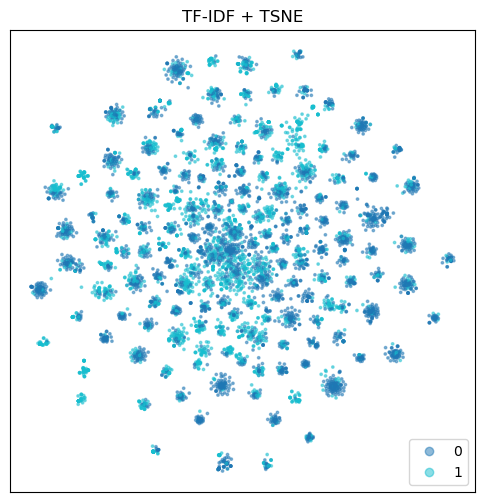

In [17]:
tsne = TSNE(n_components=2)
X_tfidf_reduced = tsne.fit_transform(X_tfidf)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc = ax.scatter(X_tfidf_reduced[:, 0], X_tfidf_reduced[:, 1], 
                c=df_train["target"], s=3, alpha=0.5, cmap="tab10")
ax.legend(handles=sc.legend_elements()[0], labels=[0, 1], loc="lower right")
ax.set_title("TF-IDF + TSNE")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### 2.9 Preparation of Training and Validation Datasets

In [18]:
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = \
    train_test_split(X_tfidf, df_train["target"].to_numpy(), train_size = 0.8, random_state = 1301)
X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v = \
    train_test_split(X_w2v, df_train["target"].to_numpy(), train_size = 0.8, random_state = 1301)

## 3. Model Architecture

Since TF-IDF vectorization format is suitable for multilayer perceptron model, we first test our data with deep ANN model.

### 3.1 Fully Connected Multi-layer Neural Network 

- Our model architecture is: Linear(512) + Dropout + ReLU + Linear(256) + Dropout + ReLU + Linear(1) + Sigmoid
- We get a validation accuracy of <font color="red">79.71%</font>.

Utility function for training logic.

In [19]:
def train_model(model, dl_train, dl_val, optimizer, criterion = nn.BCELoss(), n_epochs = 10, verbose = True):
    start_time = datetime.datetime.now()
    training_loss, val_loss, training_acc, val_acc = [], [], [], []
    for epoch in range(1, n_epochs+1):
        tl, vl, t_acc, v_acc = 0.0, 0.0, Accuracy(task = "binary"), Accuracy(task = "binary")
        t_acc.to(device), v_acc.to(device)

        for seqs, labels in dl_train:
            seqs, labels = seqs.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(seqs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            tl += loss.item()
            t_acc(outputs, labels)
        
        model.eval()
        with torch.no_grad():
            for seqs, labels in dl_val:
                seqs, labels = seqs.to(device), labels.float().to(device)
                outputs = model(seqs).squeeze()
                loss = criterion(outputs, labels)
                vl += loss.item()
                v_acc(outputs, labels)
        model.train()
        
        time, tl, vl, ta, va = datetime.datetime.now(), tl / len(dl_train), vl / len(dl_val), t_acc.compute(), v_acc.compute()
        training_loss.append(tl), val_loss.append(vl), training_acc.append(ta.item()), val_acc.append(va.item())
        training_time = datetime.datetime.now() - start_time
        
        if verbose:
            fmt_str = '{} Epoch {}, Training loss {:.4f}, Validation loss {:.4f}, Training Acc {:.4f}, Validation Acc {:.4f}'
            print(fmt_str.format(time, epoch, tl, vl, ta, va))

    return training_loss, val_loss, training_acc, val_acc, training_time

Utility function for plotting training results.

In [20]:
def plot_loss_and_acc(training_loss, val_loss, training_acc, val_acc):
    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
    ax[0].plot(range(1, len(training_loss)+1), training_loss, '.-', linewidth=1, label="training")
    ax[0].plot(range(1, len(val_loss)+1), val_loss, '.-', linewidth=1, label="validation")
    ax[0].legend()
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[1].plot(range(1, len(training_acc)+1), training_acc, '.-', linewidth=1, label="training")
    ax[1].plot(range(1, len(val_acc)+1), val_acc, '.-', linewidth=1, label="validation")
    ax[1].legend()
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")

In [21]:
class ANN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

In [22]:
n_epochs, lr, batch_size = 15, 5e-5, 64

dataset_train = TensorDataset(torch.from_numpy(X_train_tfidf).float(), torch.from_numpy(y_train_tfidf).float())
dataset_val = TensorDataset(torch.from_numpy(X_val_tfidf).float(), torch.from_numpy(y_val_tfidf).float())
g = torch.Generator()
g.manual_seed(0)
dataloader_train = DataLoader(dataset_train, shuffle = True, batch_size = batch_size, generator = g)
dataloader_val = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)

model = ANN(X_train_tfidf.shape[1])
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

training_loss, val_loss, training_acc, val_acc, training_time = \
        train_model(model, dataloader_train, dataloader_val, optimizer, criterion, n_epochs)

2023-10-03 22:58:21.317728 Epoch 1, Training loss 0.6921, Validation loss 0.6900, Training Acc 0.5455, Validation Acc 0.5791
2023-10-03 22:58:21.969605 Epoch 2, Training loss 0.6872, Validation loss 0.6829, Training Acc 0.5683, Validation Acc 0.5791
2023-10-03 22:58:22.612294 Epoch 3, Training loss 0.6746, Validation loss 0.6651, Training Acc 0.5686, Validation Acc 0.5791
2023-10-03 22:58:23.273591 Epoch 4, Training loss 0.6425, Validation loss 0.6276, Training Acc 0.6074, Validation Acc 0.6566
2023-10-03 22:58:23.913644 Epoch 5, Training loss 0.5837, Validation loss 0.5728, Training Acc 0.7297, Validation Acc 0.7433
2023-10-03 22:58:24.580294 Epoch 6, Training loss 0.5054, Validation loss 0.5205, Training Acc 0.8205, Validation Acc 0.7761
2023-10-03 22:58:25.248220 Epoch 7, Training loss 0.4289, Validation loss 0.4811, Training Acc 0.8608, Validation Acc 0.7899
2023-10-03 22:58:25.947124 Epoch 8, Training loss 0.3673, Validation loss 0.4599, Training Acc 0.8762, Validation Acc 0.7971


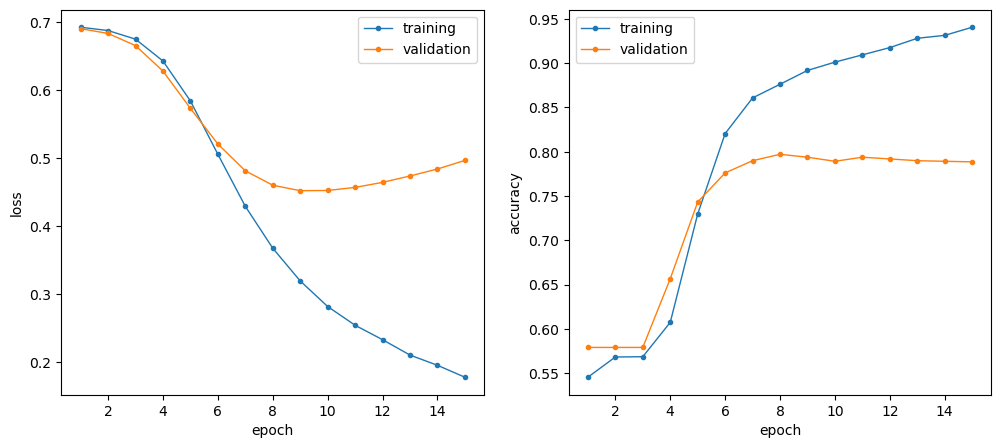

In [23]:
plot_loss_and_acc(training_loss, val_loss, training_acc, val_acc)

### 3.2 RNN (TF-IDF)

- RNN model architecture: input size = 1, hidden size = 64, number of layers = 2
- Since the sequence length of TF-IDF representation is 13,960 and most of the matrix elements are zero (sparse matrix), RNN doesn't learn well from the training data in TF-IDF format. As we can see both training and validation loss don't go down at all. 

In [24]:
class Model1(nn.Module):
    def __init__(self, vocab_vector_size):
        super().__init__()
        self.rnn = nn.RNN(
            input_size = vocab_vector_size,
            hidden_size = 64,
            num_layers = 2,
            batch_first = True,
        )
        self.fc = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64)
        h0 = h0.to(device)
        x, _ = self.rnn(x, h0)
        x = self.sigmoid(self.fc(x[:, -1, :]))
        return x

In [25]:
n_epochs, lr, batch_size = 10, 1e-4, 32

dataset_train = TensorDataset(torch.from_numpy(np.expand_dims(X_train_tfidf, axis = -1)).float(), torch.from_numpy(y_train_tfidf).float())
dataset_val = TensorDataset(torch.from_numpy(np.expand_dims(X_val_tfidf, axis = -1)).float(), torch.from_numpy(y_val_tfidf).float())
g = torch.Generator()
g.manual_seed(0)
dataloader_train = DataLoader(dataset_train, shuffle = True, batch_size = batch_size, generator = g)
dataloader_val = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)

model = Model1(1)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

training_loss, val_loss, training_acc, val_acc, training_time = \
        train_model(model, dataloader_train, dataloader_val, optimizer, criterion, n_epochs)

2023-10-03 22:58:41.349844 Epoch 1, Training loss 0.6842, Validation loss 0.6826, Training Acc 0.5681, Validation Acc 0.5791
2023-10-03 22:58:51.111201 Epoch 2, Training loss 0.6841, Validation loss 0.6817, Training Acc 0.5681, Validation Acc 0.5791
2023-10-03 22:59:00.866602 Epoch 3, Training loss 0.6840, Validation loss 0.6808, Training Acc 0.5681, Validation Acc 0.5791
2023-10-03 22:59:10.609410 Epoch 4, Training loss 0.6840, Validation loss 0.6812, Training Acc 0.5681, Validation Acc 0.5791
2023-10-03 22:59:20.340247 Epoch 5, Training loss 0.6843, Validation loss 0.6814, Training Acc 0.5681, Validation Acc 0.5791
2023-10-03 22:59:30.126434 Epoch 6, Training loss 0.6841, Validation loss 0.6803, Training Acc 0.5681, Validation Acc 0.5791
2023-10-03 22:59:39.895743 Epoch 7, Training loss 0.6837, Validation loss 0.6800, Training Acc 0.5681, Validation Acc 0.5791
2023-10-03 22:59:49.697117 Epoch 8, Training loss 0.6838, Validation loss 0.6805, Training Acc 0.5681, Validation Acc 0.5791


### 3.3 RNN (Word Embedding)

- Train RNN model against data with word embedding format.
- We get comparable result (validation accuracy = <font color="red">79.45%</font>) to deep ANN model with simpler model (fewer model parameters).

In [50]:
n_epochs, lr, batch_size = 20, 1e-4, 32

dataset_train = TensorDataset(torch.from_numpy(X_train_w2v).float(), torch.from_numpy(y_train_w2v).float())
dataset_val = TensorDataset(torch.from_numpy(X_val_w2v).float(), torch.from_numpy(y_val_w2v).float())
g = torch.Generator()
g.manual_seed(0)
dataloader_train = DataLoader(dataset_train, shuffle = True, batch_size = batch_size, generator = g)
dataloader_val = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)

model = Model1(300)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

training_loss, val_loss, training_acc, val_acc, training_time = \
        train_model(model, dataloader_train, dataloader_val, optimizer, criterion, n_epochs)

2023-10-04 00:14:22.297501 Epoch 1, Training loss 0.6862, Validation loss 0.6828, Training Acc 0.5567, Validation Acc 0.5785
2023-10-04 00:14:23.245372 Epoch 2, Training loss 0.6835, Validation loss 0.6814, Training Acc 0.5686, Validation Acc 0.5785
2023-10-04 00:14:24.143461 Epoch 3, Training loss 0.6819, Validation loss 0.6783, Training Acc 0.5703, Validation Acc 0.5804
2023-10-04 00:14:25.080736 Epoch 4, Training loss 0.6725, Validation loss 0.6708, Training Acc 0.6002, Validation Acc 0.6120
2023-10-04 00:14:25.988325 Epoch 5, Training loss 0.6374, Validation loss 0.5925, Training Acc 0.6535, Validation Acc 0.6881
2023-10-04 00:14:26.876512 Epoch 6, Training loss 0.5358, Validation loss 0.5278, Training Acc 0.7433, Validation Acc 0.7577
2023-10-04 00:14:27.783891 Epoch 7, Training loss 0.4790, Validation loss 0.5087, Training Acc 0.7859, Validation Acc 0.7754
2023-10-04 00:14:28.668853 Epoch 8, Training loss 0.4465, Validation loss 0.5052, Training Acc 0.8130, Validation Acc 0.7735


### 3.4 Model Candidates
In addtition to Model1, we design two other architectures for further training and parameter tuning:
- Model2: LSTM architecture with hidden size = 128, number of layers = 4, and dropout = 0.5
- Model3: GRU architecture with hidden size = 128, number of layers = 4, and dropout = 0.5

In [27]:
class Model2(nn.Module):
    def __init__(self, vocab_vector_size):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = vocab_vector_size,
            hidden_size = 128,
            num_layers = 4,
            batch_first = True,
            dropout = 0.5
        )
        self.fc = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(4, x.size(0), 128)
        h0 = h0.to(device)
        c0 = torch.zeros(4, x.size(0), 128)
        c0 = c0.to(device)
        x, _ = self.lstm(x, (h0, c0))
        x = self.sigmoid(self.fc(x[:, -1, :]))
        return x

In [28]:
class Model3(nn.Module):
    def __init__(self, vocab_vector_size):
        super().__init__()
        self.gru = nn.GRU(
            input_size = vocab_vector_size,
            hidden_size = 128,
            num_layers = 4,
            batch_first = True,
            dropout = 0.5
        )
        self.fc = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(4, x.size(0), 128)
        h0 = h0.to(device)
        x, _ = self.gru(x, h0)
        x = self.sigmoid(self.fc(x[:, -1, :]))
        return x

### 3.5 Hyperparameter Tuning

Directions:
- Two different models: LSTM and GRU
- Effect of different learning rates
- Effect of different batch sizes

In [29]:
parameter_set = [
        {"n_epochs": 30, "lr": 1e-4, "batch_size": 16, "model": Model2(300)},
        {"n_epochs": 30, "lr": 3e-5, "batch_size": 16, "model": Model2(300)},
        {"n_epochs": 30, "lr": 1e-5, "batch_size": 16, "model": Model2(300)},
        {"n_epochs": 30, "lr": 3e-6, "batch_size": 16, "model": Model2(300)},
        {"n_epochs": 30, "lr": 1e-4, "batch_size": 32, "model": Model2(300)},
        {"n_epochs": 30, "lr": 3e-5, "batch_size": 32, "model": Model2(300)},
        {"n_epochs": 30, "lr": 1e-5, "batch_size": 32, "model": Model2(300)},
        {"n_epochs": 30, "lr": 3e-6, "batch_size": 32, "model": Model2(300)},
        {"n_epochs": 30, "lr": 1e-4, "batch_size": 64, "model": Model2(300)},
        {"n_epochs": 30, "lr": 3e-5, "batch_size": 64, "model": Model2(300)},
        {"n_epochs": 30, "lr": 1e-5, "batch_size": 64, "model": Model2(300)},
        {"n_epochs": 30, "lr": 3e-6, "batch_size": 64, "model": Model2(300)},
        {"n_epochs": 30, "lr": 1e-4, "batch_size": 16, "model": Model3(300)},
        {"n_epochs": 30, "lr": 3e-5, "batch_size": 16, "model": Model3(300)},
        {"n_epochs": 30, "lr": 1e-5, "batch_size": 16, "model": Model3(300)},
        {"n_epochs": 30, "lr": 3e-6, "batch_size": 16, "model": Model3(300)},
        {"n_epochs": 30, "lr": 1e-4, "batch_size": 32, "model": Model3(300)},
        {"n_epochs": 30, "lr": 3e-5, "batch_size": 32, "model": Model3(300)},
        {"n_epochs": 30, "lr": 1e-5, "batch_size": 32, "model": Model3(300)},
        {"n_epochs": 30, "lr": 3e-6, "batch_size": 32, "model": Model3(300)},
        {"n_epochs": 30, "lr": 1e-4, "batch_size": 64, "model": Model3(300)},
        {"n_epochs": 30, "lr": 3e-5, "batch_size": 64, "model": Model3(300)},
        {"n_epochs": 30, "lr": 1e-5, "batch_size": 64, "model": Model3(300)},
        {"n_epochs": 30, "lr": 3e-6, "batch_size": 64, "model": Model3(300)},
]

In [30]:
result_set = []
for param in parameter_set:
    n_epochs, lr, batch_size = param["n_epochs"], param["lr"], param["batch_size"]

    dataset_train = TensorDataset(torch.from_numpy(X_train_w2v).float(), torch.from_numpy(y_train_w2v).float())
    dataset_val = TensorDataset(torch.from_numpy(X_val_w2v).float(), torch.from_numpy(y_val_w2v).float())
    g = torch.Generator()
    g.manual_seed(0)
    dataloader_train = DataLoader(dataset_train, shuffle = True, batch_size = batch_size, generator = g)
    dataloader_val = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)
    
    model = param["model"]
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)

    training_loss, val_loss, training_acc, val_acc, training_time = \
            train_model(model, dataloader_train, dataloader_val, optimizer, criterion, n_epochs, False)
    result_set.append({"training_loss": training_loss, "val_loss": val_loss, 
                        "training_acc": training_acc, "val_acc": val_acc,
                        "training_time": training_time
                      })

## 4. Results and Analysis

### 4.1 Results Summary

The following table summarizes and compares the training results of the parameter set:
- In all three architectures (RNN, LSTM, and GRU), we can observe signs of overfitting. So we add dropout in Model2 (LSTM) and Model3 (GRU) for regularization.
- Model2 (LSTM) performs better than Model1 and Model3, it achieves lowest validation loss (<font color="red">0.432212</font>) and highest validation accuracy (<font color="red">81.94%</font>).
- From Test case 4 to Test case 7, we tweak the learning rate and discover that it only affects the speed of convergence but doesn't change much to the training results. It can be explained that the Adam optimizer is not sensitive to learning rate in this range (1e-4 to 3e-6). Although not shown in the table, we have tried larger learning rate (for example 0.1) and the training becomes unstable.
- In Test case 0, 8, 12, and 20, we test the effect of batch size. However, no obvious difference is observed in these settings.
- We try to put more regularization in the model (with higher dropout probability) and the result doesn't improve. We pick the setting of Test case 2 as our final model.

In [31]:
test_cases = pd.DataFrame(parameter_set)
test_cases["model"] = test_cases["model"].apply(str).str[:6]
min_training_loss, min_val_loss, max_training_acc, max_val_acc, optimal_epoch, training_time = [], [], [], [], [], []
for result in result_set:
    min_training_loss.append(min(result["training_loss"]))
    min_val_loss.append(min(result["val_loss"]))
    max_training_acc.append(max(result["training_acc"]))
    max_val_acc.append(max(result["val_acc"]))
    optimal_epoch.append(np.argmin(result["val_loss"]) + 1)
    training_time.append(result["training_time"].seconds)

test_cases["min training loss"] = min_training_loss
test_cases["min validation loss"] = min_val_loss
test_cases["max training accuracy"] = max_training_acc
test_cases["max validation accuracy"] = max_val_acc
test_cases["optimal_epoch"] = optimal_epoch
test_cases["training_time (s)"] = training_time

test_cases

,n_epochs,lr,batch_size,model,min training loss,min validation loss,max training accuracy,max validation accuracy,optimal_epoch,training_time (s)
0,30,0.000100,16,Model2,0.100457,0.439213,0.972085,0.812213,2,56
1,30,0.000030,16,Model2,0.149864,0.445119,0.961084,0.810900,4,55
2,30,0.000010,16,Model2,0.310385,0.432212,0.884072,0.819435,12,56
3,30,0.000003,16,Model2,0.437829,0.454044,0.811166,0.787262,30,55
4,30,0.000100,32,Model2,0.117606,0.437333,0.969130,0.809586,2,29
5,30,0.000030,32,Model2,0.181449,0.438971,0.948440,0.812213,6,28
6,30,0.000010,32,Model2,0.348192,0.442728,0.864696,0.808930,23,28
7,30,0.000003,32,Model2,0.449655,0.467477,0.804926,0.786605,29,28
8,30,0.000100,64,Model2,0.134830,0.442211,0.964696,0.801707,3,19
9,30,0.000030,64,Model2,0.219987,0.467606,0.935961,0.804334,10,18


In [32]:
def plot_losses(result_idx, titles):
    fig, ax = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (12, 8))
    for i, idx in enumerate(result_idx):
        ax[i//2, i%2].plot(range(1, len(result_set[idx]["training_loss"])+1), result_set[idx]["training_loss"], marker = ".", linewidth = 1, label = "training")
        ax[i//2, i%2].plot(range(1, len(result_set[idx]["val_loss"])+1), result_set[idx]["val_loss"], marker = ".", linewidth = 1, label = "validation")
        ax[i//2, i%2].set_ylim([0, 1.0])
        if (i%2 == 0):
            ax[i//2, i%2].set_ylabel("Loss")
        if (i//2 == 1):
            ax[i//2, i%2].set_xlabel("# of epochs")
        ax[i//2, i%2].set_title(titles[i])
        ax[i//2, i%2].legend()
    plt.show()

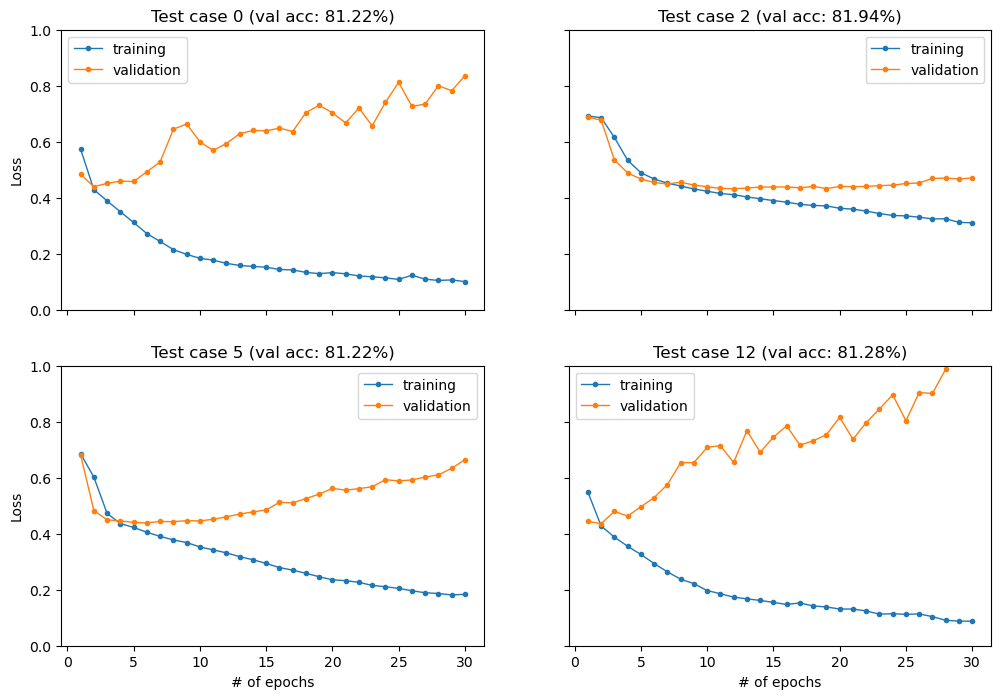

In [44]:
plot_losses([0, 2, 5, 12], ["Test case 0 (val acc: 81.22%)", "Test case 2 (val acc: 81.94%)", "Test case 5 (val acc: 81.22%)", "Test case 12 (val acc: 81.28%)"])

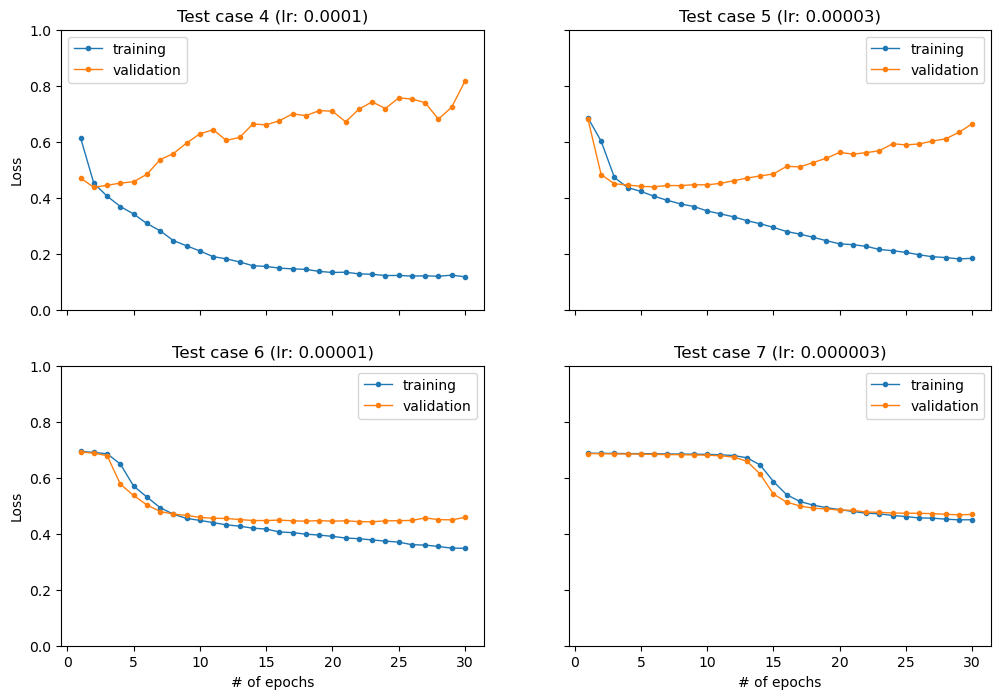

In [34]:
plot_losses([4, 5, 6, 7], ["Test case 4 (lr: 0.0001)", "Test case 5 (lr: 0.00003)", "Test case 6 (lr: 0.00001)", "Test case 7 (lr: 0.000003)"])

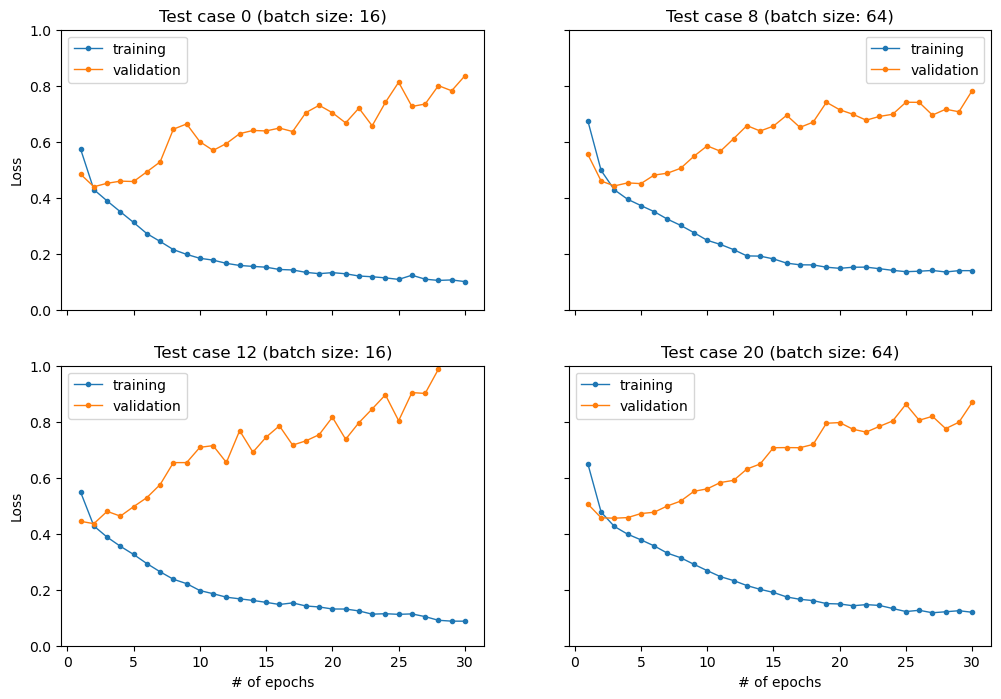

In [35]:
plot_losses([0, 8, 12, 20], ["Test case 0 (batch size: 16)", "Test case 8 (batch size: 64)", "Test case 12 (batch size: 16)", "Test case 20 (batch size: 64)"])

### 4.2 Final Model Training with Optimal Hyperparameters

In [45]:
n_epochs, lr, batch_size = 12, 1e-5, 16

dataset_train = TensorDataset(torch.from_numpy(X_train_w2v).float(), torch.from_numpy(y_train_w2v).float())
dataset_val = TensorDataset(torch.from_numpy(X_val_w2v).float(), torch.from_numpy(y_val_w2v).float())
g = torch.Generator()
g.manual_seed(0)
dataloader_train = DataLoader(dataset_train, shuffle = True, batch_size = batch_size, generator = g)
dataloader_val = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)

final_model = Model2(300)
final_model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(final_model.parameters(), lr=lr)

training_loss, val_loss, training_acc, val_acc, training_time = \
        train_model(final_model, dataloader_train, dataloader_val, optimizer, criterion, n_epochs, False)

In [46]:
dataloader_val = DataLoader(dataset_val, batch_size = 32, num_workers = 4)

val_outputs, val_labels = None, None

final_model.eval()
with torch.no_grad():
    for seqs, labels in dataloader_val:
        seqs, labels = seqs.to(device), labels.float().to(device)
        outputs = final_model(seqs).squeeze()
        if val_outputs is None or val_labels is None:
            val_outputs = outputs
            val_labels = labels
        else:
            val_outputs = torch.concatenate((val_outputs, outputs), 0)
            val_labels = torch.concatenate((val_labels, labels), 0)

val_outputs = val_outputs.cpu().numpy()
val_labels = val_labels.cpu().numpy()
final_model.train();


### 4.3 F1 Score, Confustion Matrix, and ROC Curve of the Final Model

In [47]:
f1 = f1_score(val_outputs>0.5, val_labels)
print("F1 score: {:.2f}".format(f1))

F1 score: 0.75


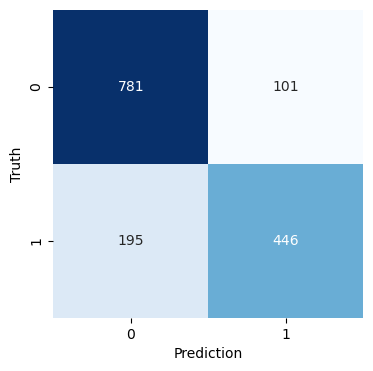

In [48]:
cm = confusion_matrix(val_labels, (val_outputs>0.5).astype(int))
df_cm = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
plt.figure(figsize=(4, 4))
hm = sns.heatmap(df_cm, annot=True, fmt=',.0f', cmap="Blues", cbar=False)
hm.set_xlabel("Prediction")
hm.set_ylabel("Truth");

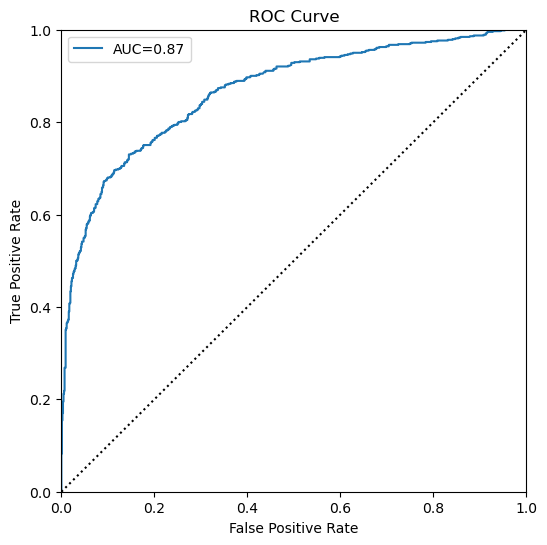

In [49]:
fpr, tpr, _ = roc_curve(val_labels, val_outputs)
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, label="AUC={auc:.2f}".format(auc=roc_auc_score(val_labels, val_outputs)))
ax.plot([0, 1], [0, 1], "k:")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
ax.legend()
plt.show()

### 4.4 Preparing for Kaggle Submission

In [41]:
dataset_test = TensorDataset(torch.from_numpy(X_test_w2v).float())
dataloader_test = DataLoader(dataset_test, batch_size = 32)

test_outputs = None

final_model.eval()
with torch.no_grad():
    for seqs in dataloader_test:
        seqs = seqs[0].to(device)
        outputs = final_model(seqs).squeeze()
        if test_outputs is None:
            test_outputs = outputs
        else:
            test_outputs = torch.concatenate((test_outputs, outputs), 0)

test_outputs = test_outputs.cpu().numpy()
test_ids = df_test["id"].to_numpy()
final_model.train();

In [42]:
pd.DataFrame({"id": test_ids, "target": (test_outputs > 0.5).astype(int)}).to_csv("submission.csv", index = False)

### 4.5 Test Results

- <font color="red">Public Score = 0.79037</font>

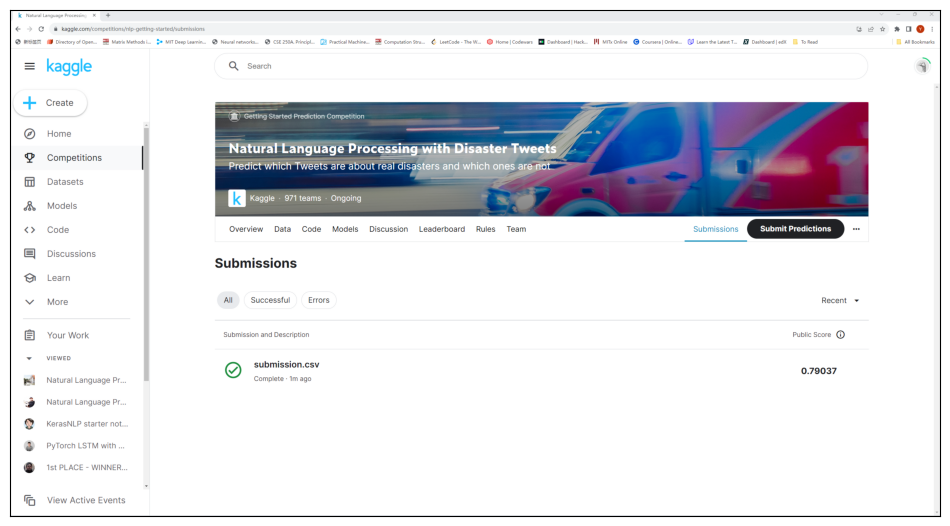

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(cv2.cvtColor(cv2.imread("images/kaggle_results.png"), cv2.COLOR_BGR2RGB))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## 5. Discussion and Conclusion

### 5.1 Learning and Takeaways
- TF-IDF is not a suitable data format for sequential neural network. It has high dimensionality, lot of zeros, and without meaningful relationship among value sequence.
- The most obvious problem of this study is that there isn't enough data. Neural network can capture complex patterns in data but at the same time requires vast amount of data. We apply relatively simple models (both normal ANN and sequential neural network) but still show signs of overfitting. Increasing complexity of the model doesn't help much with the performance.
- Taking a preliminary look in the data, it is often the case that certain one or couple of keywords determine if the tweet is disastrous or not. So the ability of sequential neural network to capture long-term dependencies in sentences doesn't bring into play much in this study. And we can see that model like LSTM only improves marginally when comparing with normal ANN model.
- For the final model, <font color="blue">precision = (TP)/(TP+FP) = 446/(446+101) = 81.54%</font> and <font color="blue">recall = (TP)/(TP+FN) = 446/(446+195) = 69.58%</font>. It seems that our model predicts relatively more false negative cases (miss the actual disasters). In the application scenario described in the introduction section, this kind of misclassification is more unacceptable than the false positive ones.
- The difference between validation and test F1 score is greater than expected (0.75 vs 0.7903, the model generalizes well). The explanation of this requires further examination.
- In this study, tuning learning rate and batch size do not improve much to the model performance. In fact, model performance is not even senstive to model complexity. This is also why we believe that more data is needed for achieving better performance.

### 5.2 Possible Future Works
- Generally speaking, Adam tends to converge faster, while SGD often converges to more optimal solutions but requires more effort in parameter tuning. We may change the optimizer in this study to SGD to see if better result could be achieved.
- Apply other word embedding models
- Try possible data augmentation techniques to alleviate the problem of insufficient data
